# Classification for CIFAR-10

In [1]:
import torch

## Dataset loading

In [2]:
import torchvision as tv
import torchvision.transforms as transforms


In [3]:
train_dataset=tv.datasets.CIFAR10('./data', train=True, download=True,
                                transform=transforms.ToTensor())
test_dataset=tv.datasets.CIFAR10('./data', train=False, download=True,
                               transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [4]:
data, label=train_dataset[3692]

In [5]:
data.shape, label

(torch.Size([3, 32, 32]), 2)

In [6]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
train_dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

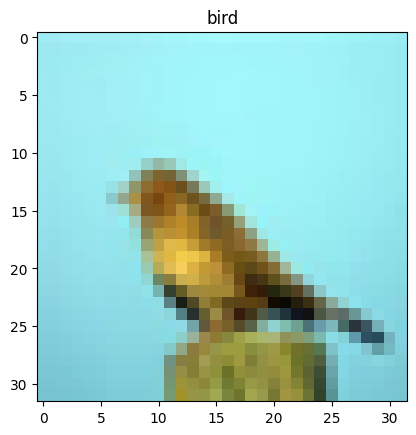

In [8]:
import matplotlib.pyplot as plt
plt.imshow(data.permute(1,2,0))
plt.title(train_dataset.classes[label])
plt.show()

## Dataloader

In [9]:
from torch.utils.data import DataLoader

In [10]:
batch_size=32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                         shuffle=False)


In [11]:
for ddata, ddlabel in train_loader:
  print(ddata.shape, ddlabel)
  break

torch.Size([32, 3, 32, 32]) tensor([9, 5, 3, 5, 2, 2, 3, 6, 6, 3, 9, 0, 2, 4, 5, 3, 8, 4, 7, 0, 5, 0, 8, 9,
        3, 9, 6, 6, 7, 1, 6, 7])


## Creating Model

In [12]:
import torch.nn as nn

In [13]:
class GENMODEL(nn.Module):
  def __init__(self, input_layer_node, ouput_layer_node):
    super(GENMODEL, self).__init__()
    print("My first Model is created")
    self.flatten= nn.Flatten()
    self.input=nn.Linear(in_features=input_layer_node, out_features=128)
    self.hidden=nn.Linear(in_features=128, out_features=64)
    self.output=nn.Linear(in_features=64, out_features=ouput_layer_node)
    self.relu=nn.ReLU()
  def forward(self, x):
    x=self.flatten(x) # preprocessign 28X28 --> 784
    x = self.input(x) # input layer
    x=self.relu(x)
    x=self.hidden(x) # hidden layer
    x=self.relu(x)
    x=self.output(x) # output layer
    return x

In [14]:
class GENMODELv2(nn.Module):
  def __init__(self, input_layer_node, ouput_layer_node):
    super(GENMODELv2, self).__init__()
    print("My first Model is created")
    self.flatten= nn.Flatten()
    self.input=nn.Linear(in_features=input_layer_node, out_features=1024)
    self.hidden1=nn.Linear(in_features=1024, out_features=512)
    self.hidden2=nn.Linear(in_features=512, out_features=128)
    self.hidden3=nn.Linear(in_features=128, out_features=64)
    self.output=nn.Linear(in_features=64, out_features=ouput_layer_node)
    self.relu=nn.ReLU()
  def forward(self, x):
    x=self.flatten(x) # preprocessign 32X32 --> 3072
    x = self.input(x) # input layer
    x=self.relu(x)
    x=self.hidden1(x) # hidden layer
    x=self.relu(x)
    x=self.hidden2(x) # hidden layer
    x=self.relu(x)
    x=self.hidden3(x) # hidden layer
    x=self.relu(x)
    x=self.output(x) # output layer
    return x

In [15]:
data_input, label=train_dataset[0]

In [16]:
input_size=data_input.shape[0]*data_input.shape[1]*data_input.shape[2]
input_size

3072

In [17]:
output_size=len(train_dataset.classes)

In [18]:
model=GENMODELv2(input_size,output_size)
model

My first Model is created


GENMODELv2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (input): Linear(in_features=3072, out_features=1024, bias=True)
  (hidden1): Linear(in_features=1024, out_features=512, bias=True)
  (hidden2): Linear(in_features=512, out_features=128, bias=True)
  (hidden3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
)

In [19]:
for ddata, ddlabel in train_loader:
  print("Before", ddata.shape)
  out=model(ddata)
  print("aftr feedforward",out.shape)
  break

Before torch.Size([32, 3, 32, 32])
aftr feedforward torch.Size([32, 10])


## Optimizer and Loss

In [20]:
import torch.optim as optim

In [21]:
loss_fn = nn.CrossEntropyLoss()
learning_rate=0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

### Model to GPU

In [22]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [23]:
model=model.to(device)

## Training Loop

In [35]:
import time
from tqdm import tqdm
import numpy as np
start_time=time.time()
max_epoch=3
training_data=[]
for epoch in range(max_epoch):
  # pass data through model for training
  mean_train_loss=0
  mean_val_loss=0
  for data, label in tqdm(train_loader):
    # print(data.shape, label)
    # Put data to GPU
    data=data.to(device)
    label=label.to(device)
    # Feed forward
    out=model(data)
    # print(out.shape)
    # Training Loss calculation
    train_loss=loss_fn(out, label)
    # print(train_loss)
    # Backward pass and optimization
    optimizer.zero_grad()
    # backprop
    train_loss.backward()
    # weight updation
    optimizer.step()
    # print("train loss ",train_loss)
    mean_train_loss+=train_loss.item()
    # break
  # validation
  total=0
  correct=0
  with torch.no_grad():
    for data, label in tqdm(test_loader):
      # print(data.shape, label)
      # Put data to GPU
      data=data.to(device)
      label=label.to(device)
      # Feed forward
      out=model(data)
      # print(out.shape)
      # validation Loss calculation
      val_loss=loss_fn(out, label)
      # print("val loss ",val_loss)

      _, predicted = torch.max(out, 1)
      total += label.size(0)
      correct += (predicted == label).sum().item()
      mean_val_loss+=val_loss
      # break
  mean_train_loss = mean_train_loss/len(train_loader)
  mean_test_loss = mean_val_loss/len(test_loader)
  accuracy = correct / total
  training_data.append({"Train_loss": mean_train_loss,
                        "val_loss": mean_test_loss.item(),
                        "accuracy": accuracy,
                        "epoch": epoch})
  print('\nEpoch: {}/{} train Loss :{:.4f} Test Loss:{:.4f}  Test Accuracy: {:.4f}'
  .format(epoch,max_epoch, mean_train_loss, mean_test_loss, accuracy*100))
end_time=time.time()

100%|██████████| 313/313 [00:03<00:00, 96.98it/s] 



Epoch: 0/3 train Loss :2.2303 Test Loss:2.0493  Test Accuracy: 22.9600


100%|██████████| 313/313 [00:03<00:00, 102.29it/s]



Epoch: 1/3 train Loss :1.9646 Test Loss:1.8763  Test Accuracy: 31.1700


100%|██████████| 313/313 [00:03<00:00, 103.64it/s]


Epoch: 2/3 train Loss :1.8443 Test Loss:1.7762  Test Accuracy: 35.8500


## Time Complexity

In [36]:
end_time - start_time

94.99760723114014

## Train validation Accuracy plot

In [37]:
import pandas as pd
import seaborn as sns

C:\Users\vwadhawan\AppData\Local\Temp\ipykernel_1712\432526209.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [38]:
df=pd.DataFrame(training_data)
df

,Train_loss,val_loss,accuracy,epoch
0,2.230299,2.049281,0.2296,0
1,1.964606,1.876281,0.3117,1
2,1.844260,1.776170,0.3585,2


<Axes: xlabel='epoch', ylabel='Train_loss'>

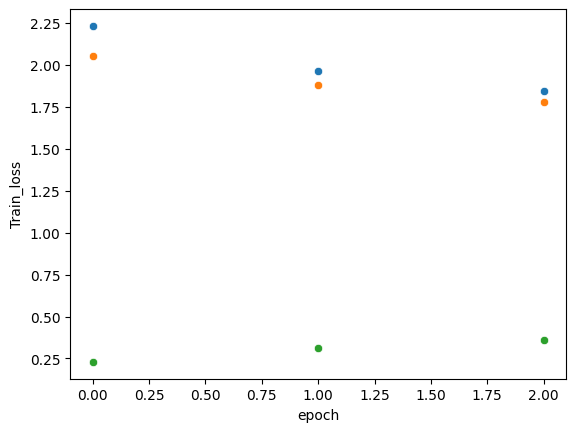

In [39]:
sns.scatterplot(data=df, x='epoch', y='Train_loss')
sns.scatterplot(data=df, x='epoch', y='val_loss')
sns.scatterplot(data=df, x='epoch', y='accuracy')


## Model weights visualization

In [40]:
model.input.weight.data.shape

torch.Size([1024, 3072])

In [41]:
model.hidden1.weight.data.shape

torch.Size([512, 1024])

In [42]:
model.hidden2.weight.data

tensor([[-0.0288, -0.0427, -0.0066,  ..., -0.0101, -0.0297, -0.0257],
        [-0.0441, -0.0115,  0.0112,  ..., -0.0428,  0.0226,  0.0311],
        [-0.0301, -0.0388, -0.0302,  ..., -0.0252, -0.0241, -0.0050],
        ...,
        [ 0.0281, -0.0387,  0.0246,  ..., -0.0454,  0.0134, -0.0356],
        [-0.0133, -0.0060,  0.0285,  ..., -0.0310, -0.0186,  0.0007],
        [-0.0289, -0.0101,  0.0283,  ...,  0.0361, -0.0118, -0.0004]])

In [43]:
w3=model.hidden3.weight.data

In [44]:
#import matplotlib.pyplot as plt
#plt.imshow(w3.cpu().numpy())
#plt.show()

## Save the torch model

In [45]:
torch.save(model.state_dict(), 'model_weights.pth')